In [130]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import numpy as np

In [131]:
with open('./data/LLMsuggestions_free_uncommented.json', 'r') as f1:
    LLMResults = json.load(f1)

with open('./data/allTables_free.json', 'r') as f2:
    MznResults = json.load(f2)

In [132]:
# --- Flatten LLMResults into llm_df ---
def ResultsFlattener(LLMResults):
    llm_rows = []
    for provider, models in (LLMResults or {}).items():
        if not isinstance(models, dict):
            continue
        for model, problems in models.items():
            if not isinstance(problems, dict):
                continue
            for problem, instances in problems.items():
                if not isinstance(instances, dict):
                    continue
                for instance, data in instances.items():
                    if not isinstance(data, dict):
                        top3_val = None
                        time_val = None
                    else:
                        top3_val = data.get('top3') if 'top3' in data else data.get('top_3') if 'top_3' in data else data.get('suggested') if 'suggested' in data else None
                        time_val = data.get('time_seconds') if 'time_seconds' in data else data.get('time') if 'time' in data else None
                    if isinstance(top3_val, list):
                        top3_list = top3_val
                        top3_str = ', '.join(map(str, top3_list)) if top3_list else None
                        top1 = top3_list[0] if top3_list else None
                    elif isinstance(top3_val, str):
                        parts = [p.strip() for p in top3_val.replace(';',',').split(',') if p.strip()]
                        top3_list = parts if parts else None
                        top3_str = ', '.join(parts) if parts else top3_val
                        top1 = parts[0] if parts else (top3_val or None)
                    else:
                        top3_list = None
                        top3_str = None
                        top1 = None
                    llm_rows.append({
                        'provider': provider,
                        'model': model,
                        'problem': problem,
                        'instance': instance,
                        'top3_list': top3_list,
                        'top3': top3_str,
                        'top1': top1,
                        'time_seconds': time_val
                    })

    llm_df = pd.DataFrame(llm_rows)
    if not llm_df.empty:
        llm_df['time_seconds'] = pd.to_numeric(llm_df['time_seconds'], errors='coerce')
    return llm_df

llm_df = ResultsFlattener(LLMResults)
print('LLM DataFrame shapes and example:')
print('llm_df.shape =', llm_df.shape)
display(llm_df.head(10))


LLM DataFrame shapes and example:
llm_df.shape = (1007, 8)


,provider,model,problem,instance,top3_list,top3,top1,time_seconds
0,gemini,gemini-2.5-flash,atsp,instance4_0p15,"[or-tools_cp-sat-free, cp_optimizer-free, chuf...","or-tools_cp-sat-free, cp_optimizer-free, chuff...",or-tools_cp-sat-free,24.238
1,gemini,gemini-2.5-flash,atsp,instance20_0p35,"[or-tools_cp-sat-free, cp_optimizer-free, chuf...","or-tools_cp-sat-free, cp_optimizer-free, chuff...",or-tools_cp-sat-free,27.641
2,gemini,gemini-2.5-flash,atsp,instance14_0p25,"[cp_optimizer-free, or-tools_cp-sat-free, chuf...","cp_optimizer-free, or-tools_cp-sat-free, chuff...",cp_optimizer-free,17.376
3,gemini,gemini-2.5-flash,atsp,instance1_0p05,"[or-tools_cp-sat-free, chuffed-free, choco-sol...","or-tools_cp-sat-free, chuffed-free, choco-solv...",or-tools_cp-sat-free,20.425
4,gemini,gemini-2.5-flash,atsp,instance11_0p25,"[or-tools_cp-sat-free, cp_optimizer-free, choc...","or-tools_cp-sat-free, cp_optimizer-free, choco...",or-tools_cp-sat-free,26.904
5,gemini,gemini-2.5-flash,black-hole,layout_17,"[or-tools_cp-sat-free, chuffed-free, cp_optimi...","or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,16.390
6,gemini,gemini-2.5-flash,black-hole,layout_25,"[cp_optimizer-free, chuffed-free, or-tools_cp-...","cp_optimizer-free, chuffed-free, or-tools_cp-s...",cp_optimizer-free,15.309
7,gemini,gemini-2.5-flash,black-hole,layout_3,"[or-tools_cp-sat-free, chuffed-free, cp_optimi...","or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,20.054
8,gemini,gemini-2.5-flash,black-hole,layout_14,"[or-tools_cp-sat-free, cp_optimizer-free, chuf...","or-tools_cp-sat-free, cp_optimizer-free, chuff...",or-tools_cp-sat-free,22.178
9,gemini,gemini-2.5-flash,black-hole,layout_27,"[or-tools_cp-sat-free, chuffed-free, cp_optimi...","or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,22.277


In [133]:
def mznResultsFlattener(MznResults):
    rows = []

    for problem, problem_data in MznResults.items():
        category = problem_data.get("category")
        
        for instance, solvers in problem_data.items():
            if instance == "category":
                continue  # skip category entry
            for solver_entry in solvers:
                rows.append({
                    "Problem": problem,
                    "Category": category,
                    "Instance": instance,
                    "Solver": solver_entry.get("Solver"),
                    "Status": solver_entry.get("Status"),
                    "Time": solver_entry.get("Time"),
                    "Objective": solver_entry.get("Objective"),
                    "Score": solver_entry.get("Score"),
                    "Score Area": solver_entry.get("Score Area"),
                })

    df = pd.DataFrame(rows)

    # Convert numeric columns
    numeric_cols = ["Time", "Objective", "Score", "Score Area"]
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

    return df

df = mznResultsFlattener(MznResults)
# Inspect the result
display(df.head())
print(df.shape)

,Problem,Category,Instance,Solver,Status,Time,Objective,Score,Score Area
0,EchoSched,MIN,12-12-0-1_7,atlantis-free,UNK,1200000.0,NaN,0.00,1200000.00
1,EchoSched,MIN,12-12-0-1_7,cbc-free,S,1200000.0,12172.0,5.00,326862.67
2,EchoSched,MIN,12-12-0-1_7,choco-solver__cp_-free,SC,38449.0,12135.0,10.54,14001.39
3,EchoSched,MIN,12-12-0-1_7,choco-solver__cp-sat_-free,SC,48686.0,12135.0,10.03,17561.17
4,EchoSched,MIN,12-12-0-1_7,chuffed-free,SC,6508.0,12135.0,15.05,4352.61


(2000, 9)


### Solver Score Calculation

For each solver \( s \) and instance \( i \), we compute a **score** that reflects the solver’s performance according to the rules below.  
This metric applies to both **satisfaction** and **optimization** problems.

#### Definitions

- \( sol(s, i) \): status returned by the solver  
  (possible values: `S`, `C`, `ERR`, `UNK`, `UNSAT`, etc.)
- \( val(s, i) \): objective value obtained by the solver  
- \( best(i) \): best (optimal) objective value across all solvers for that instance  
- \( worst(i) \): worst (non-error) objective value across all solvers for that instance  
- \( category(i) \): either **MIN** or **MAX**, defining whether lower or higher objectives are better  

The mapping between MiniZinc statuses and the symbolic statuses in the formula is:

| Status | Meaning | Formula Status |
|---------|----------|----------------|
| `S`, `SC` | Found a feasible solution | `SAT` |
| `C` with best objective | Optimal or proven UNSAT | `OPT` |
| `ERR` | Error or crash | `ERR` |
| `UNK` | No answer within time limit | `UNK` |



### Formula (for Minimization)

$$
score(s,i) =
\begin{cases}
0 & \text{if } sol(s,i) \in \{UNK, ERR\} \\
1 & \text{if } sol(s,i) \in \{UNSAT, OPT\} \\
0.25 + 0.5 \cdot \frac{val(s,i) - worst(i)}{best(i) - worst(i)} & \text{if } sol(s,i) = SAT
\end{cases}
$$

For **maximization problems**, the ratio in the last term is inverted.

In [134]:
# Work on a copy
scored_df = df.copy()

def scoreComputation(scored_df):
    # Normalize Status column
    scored_df['Status'] = scored_df['Status'].astype(str).str.upper()

    # Only consider numeric Objectives for best/worst computation
    valid_mask = scored_df['Status'].isin(['S', 'C']) & scored_df['Objective'].notnull()
    valid_objs = scored_df.loc[valid_mask, ['Problem', 'Instance', 'Objective', 'Category']]

    # Compute best/worst per instance depending on MIN/MAX
    def best_worst(group):
        cat = group['Category'].iloc[0].upper()
        if cat == 'MIN':
            best = group['Objective'].min()
            worst = group['Objective'].max()
        else:
            best = group['Objective'].max()
            worst = group['Objective'].min()
        return pd.Series({'best': best, 'worst': worst})

    agg = valid_objs.groupby(['Problem', 'Instance']).apply(best_worst).reset_index()

    # Merge back to the main dataframe
    scored_df = scored_df.merge(agg, on=['Problem', 'Instance'], how='left')

    # Determine solver-level labels (SAT vs OPT)
    def solver_label(row):
        if row['Status'] in ['UNK', 'ERR']:
            return 'UNK'
        if row['Status'] in ['S', 'SC']:
            cat = row['Category'].upper()
            if cat == 'SAT':
                return 'OPT'
            if pd.isna(row['Objective']) or pd.isna(row['best']):
                return 'SAT'
            if cat == 'MIN' and row['Objective'] <= row['best']:
                return 'OPT'
            if cat == 'MAX' and row['Objective'] >= row['best']:
                return 'OPT'
            return 'SAT'
        return row['Status']

    scored_df['DerivedStatus'] = scored_df.apply(solver_label, axis=1)

    # Compute final score
    def compute_score(row):
        stat = row['DerivedStatus']
        val = row['Objective']
        best = row['best']
        worst = row['worst']
        cat = str(row['Category']).upper()

        if stat in ['UNK', 'ERR']:
            return 0.0
        if stat in ['OPT']:
            return 1.0
        if stat == 'SAT' and pd.notnull(best) and pd.notnull(worst) and best != worst:
            if cat == 'MIN':
                return 0.25 + 0.5 * (val - worst) / (best - worst)
            elif cat == 'MAX':
                return 0.25 + 0.5 * (best - val) / (best - worst)
        return np.nan

    scored_df['ComputedScore'] = scored_df.apply(compute_score, axis=1)
    return scored_df

scored_df = scoreComputation(scored_df)
display(scored_df[scored_df['Problem'] == 'black-hole'])

/tmp/ipykernel_5851/1335936071.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg = valid_objs.groupby(['Problem', 'Instance']).apply(best_worst).reset_index()


,Problem,Category,Instance,Solver,Status,Time,Objective,Score,Score Area,best,worst,DerivedStatus,ComputedScore
200,black-hole,SAT,layout_14,atlantis-free,UNK,1200000.0,NaN,0.00,1200000.0,NaN,NaN,UNK,0.0
201,black-hole,SAT,layout_14,cbc-free,UNK,1200000.0,NaN,0.00,1200000.0,NaN,NaN,UNK,0.0
202,black-hole,SAT,layout_14,choco-solver__cp_-free,S,6422.0,NaN,16.07,6422.0,NaN,NaN,OPT,1.0
203,black-hole,SAT,layout_14,choco-solver__cp-sat_-free,S,13428.0,NaN,15.03,13428.0,NaN,NaN,OPT,1.0
204,black-hole,SAT,layout_14,chuffed-free,S,687.0,NaN,19.00,687.0,NaN,NaN,OPT,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,black-hole,SAT,layout_3,picatsat-free,S,39746.0,NaN,13.00,39746.0,NaN,NaN,OPT,1.0
296,black-hole,SAT,layout_3,pumpkin-free,UNK,1200000.0,NaN,0.00,1200000.0,NaN,NaN,UNK,0.0
297,black-hole,SAT,layout_3,scip-free,UNK,1200000.0,NaN,0.00,1200000.0,NaN,NaN,UNK,0.0
298,black-hole,SAT,layout_3,sicstus_prolog-free,UNK,1200000.0,NaN,0.00,1200000.0,NaN,NaN,UNK,0.0


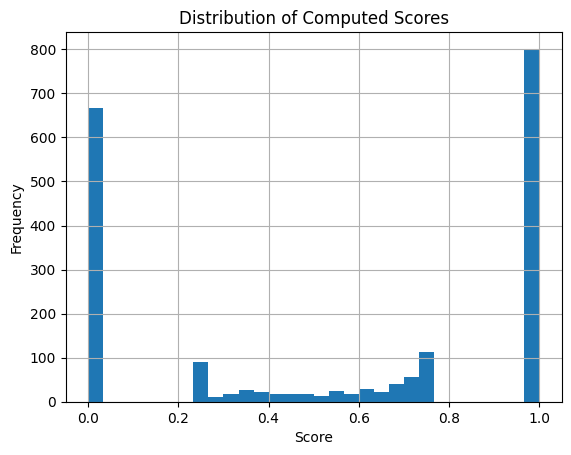

In [135]:
import matplotlib.pyplot as plt
scored_df['ComputedScore'].hist(bins=30)
plt.title('Distribution of Computed Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

In [136]:
def compute_llm_scores(llm_df, scored_df):
    llm_expanded = llm_df.copy()

    llm_expanded = llm_expanded[llm_expanded['top3_list'].notnull()].copy()
    llm_expanded = llm_expanded.explode('top3_list').rename(columns={'top3_list': 'Solver'})
    llm_expanded['Solver'] = llm_expanded['Solver'].astype(str).str.strip()

    # Standardize matching keys
    llm_expanded['problem'] = llm_expanded['problem'].astype(str)
    llm_expanded['instance'] = llm_expanded['instance'].astype(str)
    scored_df['Problem'] = scored_df['Problem'].astype(str)
    scored_df['Instance'] = scored_df['Instance'].astype(str)
    scored_df['Solver'] = scored_df['Solver'].astype(str).str.strip()

    # Merge: (problem, instance, solver)
    llm_scored = llm_expanded.merge(
        scored_df[['Problem', 'Instance', 'Solver', 'ComputedScore']],
        left_on=['problem', 'instance', 'Solver'],
        right_on=['Problem', 'Instance', 'Solver'],
        how='left'
    )

    # Treat missing matches as score 0 and compute best-of-top3 per instance
    llm_scored['ComputedScore'] = llm_scored['ComputedScore'].fillna(0.0)

    per_instance_best = (
        llm_scored
        .groupby(['provider', 'model', 'problem', 'instance'], as_index=False)
        .agg(InstanceBestScore=('ComputedScore', 'max'))
    )

    # Sum the best score per instance for each (provider, model)
    llm_summary = (
        per_instance_best
        .groupby(['provider', 'model'], as_index=False)
        .agg(
            LLM_TotalScore=('InstanceBestScore', 'sum'),
            InstancesCovered=('instance', 'nunique')
        )
    )

    llm_summary['LLM_AvgScore'] = llm_summary['LLM_TotalScore'] / llm_summary['InstancesCovered']
    return llm_summary

llm_summary = compute_llm_scores(llm_df, scored_df)

display(llm_summary.sort_values('LLM_AvgScore', ascending=False))

,provider,model,LLM_TotalScore,InstancesCovered,LLM_AvgScore
8,groq,llama-3.3-70b-versatile,9.496286,10,0.949629
5,groq,groq/compound,8.496286,9,0.944032
12,groq,moonshotai/kimi-k2-instruct,69.382589,75,0.925101
13,groq,moonshotai/kimi-k2-instruct-0905,68.598440,75,0.914646
9,groq,meta-llama/llama-4-maverick-17b-128e-instruct,65.707362,72,0.912602
14,groq,openai/gpt-oss-120b,66.666698,74,0.900901
6,groq,groq/compound-mini,31.021680,35,0.886334
10,groq,meta-llama/llama-4-scout-17b-16e-instruct,60.820849,69,0.881462
2,gemini,gemini-2.5-flash-lite,74.913813,85,0.881339
0,gemini,gemini-2.0-flash,58.296898,67,0.870103


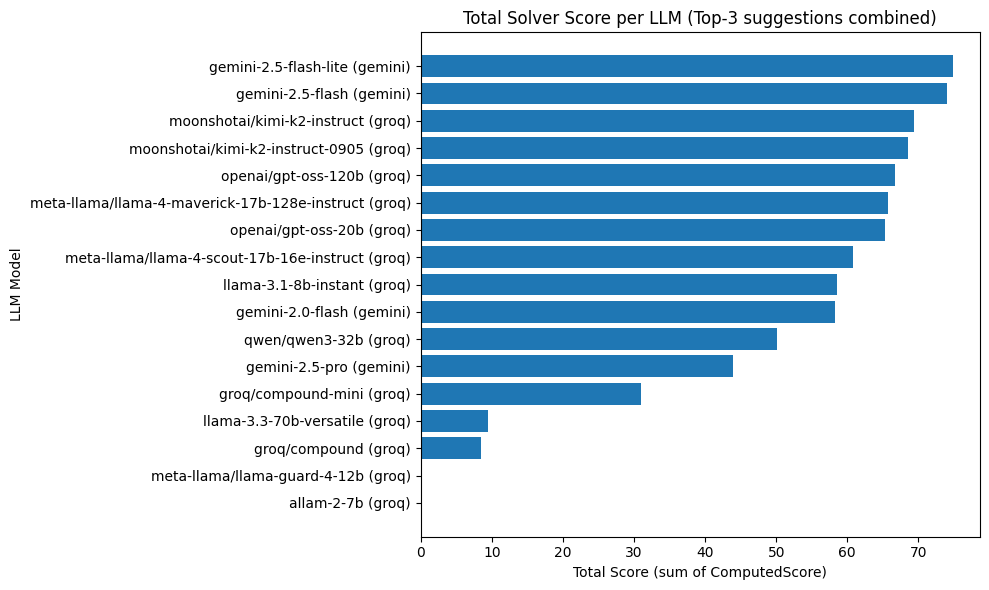

In [137]:
# Sort by total score
plot_df = llm_summary.sort_values('LLM_TotalScore', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(
    plot_df['model'] + " (" + plot_df['provider'] + ")", 
    plot_df['LLM_TotalScore']
)
plt.title("Total Solver Score per LLM (Top-3 suggestions combined)")
plt.xlabel("Total Score (sum of ComputedScore)")
plt.ylabel("LLM Model")
plt.tight_layout()
plt.show()

In [138]:
def compute_top1_llm_scores(llm_df, scored_df):
    # --- Extract Top-1 predictions only ---
    llm_top1 = llm_df.copy()
    llm_top1 = llm_top1[llm_top1['top1'].notnull()].copy()
    llm_top1 = llm_top1.rename(columns={'top1': 'Solver'})
    llm_top1['Solver'] = llm_top1['Solver'].astype(str)

    # --- Standardize key names and merge with solver scores ---
    scored_df['Problem'] = scored_df['Problem'].astype(str)
    scored_df['Instance'] = scored_df['Instance'].astype(str)
    scored_df['Solver'] = scored_df['Solver'].astype(str)

    llm_top1['problem'] = llm_top1['problem'].astype(str)
    llm_top1['instance'] = llm_top1['instance'].astype(str)

    llmTSD_scored = llm_top1.merge(
        scored_df[['Problem', 'Instance', 'Solver', 'ComputedScore']],
        left_on=['problem', 'instance', 'Solver'],
        right_on=['Problem', 'Instance', 'Solver'],
        how='left'
    )

    # --- Aggregate by (provider, model) ---
    llm_top1_summary = (
        llmTSD_scored
        .groupby(['provider', 'model'], as_index=False)
        .agg(
            LLM_Top1_TotalScore=('ComputedScore', 'sum'),
            LLM_Top1_AvgScore=('ComputedScore', 'mean'),
            InstancesCovered=('instance', 'nunique')
        )
    )

    # --- Sort descending by average score ---
    llm_top1_summary = llm_top1_summary.sort_values('LLM_Top1_TotalScore', ascending=False)
    return llm_top1_summary, llmTSD_scored

llm_top1_summary, llm_top1_scored = compute_top1_llm_scores(llm_df, scored_df)
display(llm_top1_summary)


,provider,model,LLM_Top1_TotalScore,LLM_Top1_AvgScore,InstancesCovered
2,gemini,gemini-2.5-flash-lite,67.448500,0.832698,85
1,gemini,gemini-2.5-flash,65.629788,0.781307,85
12,groq,moonshotai/kimi-k2-instruct-0905,60.940287,0.834798,75
11,groq,moonshotai/kimi-k2-instruct,60.122616,0.858895,75
13,groq,openai/gpt-oss-120b,59.422634,0.814009,74
14,groq,openai/gpt-oss-20b,59.410434,0.861021,75
9,groq,meta-llama/llama-4-maverick-17b-128e-instruct,59.053489,0.843621,72
10,groq,meta-llama/llama-4-scout-17b-16e-instruct,55.561696,0.817084,69
0,gemini,gemini-2.0-flash,49.512659,0.761733,67
15,groq,qwen/qwen3-32b,46.934275,0.853350,65


In [139]:
# Extract missing instances for a specific LLM model
model_to_check = 'gemini-2.5-flash'
llm_model_data = llm_top1_scored[llm_top1_scored['model'] == model_to_check]
# find all (problem, instance) pairs in scored_df, then remove those covered by this LLM model
scored_pairs = (
    scored_df[['Problem', 'Instance']]
    .drop_duplicates()
    .rename(columns={'Problem': 'problem', 'Instance': 'instance'})
    .astype(str)
)

covered_pairs = llm_model_data[['problem', 'instance']].drop_duplicates().astype(str)

missing_instances = (
    scored_pairs.merge(covered_pairs, on=['problem', 'instance'], how='left', indicator=True)
    .query("_merge == 'left_only'")
    .drop(columns=['_merge'])
    .reset_index(drop=True)
)
print(f"Missing instances for model '{model_to_check}':")
display(missing_instances)

Missing instances for model 'gemini-2.5-flash':


,problem,instance
0,groupsplitter,u12g2pref0
1,groupsplitter,u12g2pref2
2,groupsplitter,u15g1pref2
3,groupsplitter,u15g3pref0
4,groupsplitter,u15g5pref1
5,hitori,h11-1
6,proteindesign12,1HZ5.12p.19aa.usingEref_self
7,proteindesign12,1HZ5.12p.9aa.usingEref_self
8,proteindesign12,1UBI.13p.19aa.usingEref_self
9,proteindesign12,1UBI.13p.9aa.usingEref_self_x


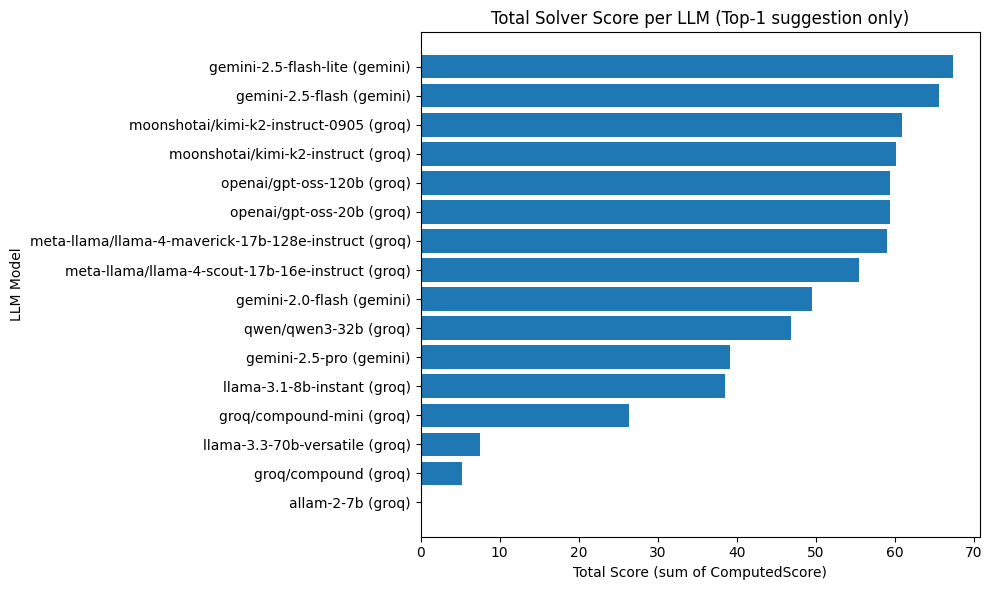

In [140]:
# Sort by total score
plot_df = llm_top1_summary.sort_values('LLM_Top1_TotalScore', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(
    plot_df['model'] + " (" + plot_df['provider'] + ")", 
    plot_df['LLM_Top1_TotalScore']
)
plt.title("Total Solver Score per LLM (Top-1 suggestion only)")
plt.xlabel("Total Score (sum of ComputedScore)")
plt.ylabel("LLM Model")
plt.tight_layout()
plt.show()

### Closed-Gap (CG) Metric Calculation

The **closed-gap (cg)** metric measures how close a solver selection (in this case, the LLM’s chosen solver) is to the *Virtual Best Solver* (VBS), normalized against the *Single Best Solver* (SBS).

#### Formula

$$
cg = \frac{score_{all}(AS) - score_{all}(SBS)}{score_{all}(VBS) - score_{all}(SBS)}
$$

where:
- **AS** = Algorithm Selector (the solver predicted by the LLM)
- **VBS** = Virtual Best Solver — the solver that achieves the best score on each instance
- **SBS** = Single Best Solver — the single solver that performs best overall across the dataset  
  (in our case: `SBS = 'or-tools_cp-sat-free'`)

In [141]:
def compute_closed_gap(llm_top1_scored, scored_df):
    SBS_SOLVER = 'or-tools_cp-sat-free'

    cg_results = []

    # Compute VBS scores for all instances once
    vbs_df = (
        scored_df.groupby(['Problem', 'Instance'], as_index=False)['ComputedScore']
        .max()
        .rename(columns={'ComputedScore': 'VBS_Score'})
    )

    for (prov, mod), group in llm_top1_scored.groupby(['provider', 'model']):
        # Instances this model actually made predictions for
        covered = group[['problem', 'instance']].drop_duplicates()
        
        # Subset SBS and VBS to same instance set
        vbs_sub = vbs_df.merge(
            covered,
            left_on=['Problem', 'Instance'],
            right_on=['problem', 'instance'],
            how='inner'
        )
        sbs_sub = scored_df[
            (scored_df['Solver'] == SBS_SOLVER)
            & (scored_df['Problem'].isin(covered['problem']))
            & (scored_df['Instance'].isin(covered['instance']))
        ]
        
        # Compute total scores normalized over same instance set
        score_AS = group['ComputedScore'].sum()
        score_VBS = vbs_sub['VBS_Score'].sum()
        score_SBS = sbs_sub['ComputedScore'].sum()

        # Compute closed gap
        cg = (score_AS - score_SBS) / (score_VBS - score_SBS) if (score_VBS - score_SBS) != 0 else float('nan')

        cg_results.append({
            'provider': prov,
            'model': mod,
            'InstancesCovered': len(covered),
            'AS': score_AS,
            'SBS': score_SBS,
            'VBS': score_VBS,
            'ClosedGap': cg,
        })
    return cg_results

cg_results = compute_closed_gap(llm_top1_scored, scored_df)

cg_df = pd.DataFrame(cg_results).sort_values('ClosedGap', ascending=False)
display(cg_df)

,provider,model,InstancesCovered,AS,SBS,VBS,ClosedGap
2,gemini,gemini-2.5-flash-lite,85,67.448500,67.585568,83.0,-0.008892
3,gemini,gemini-2.5-pro,51,39.140862,40.201589,50.0,-0.108255
1,gemini,gemini-2.5-flash,85,65.629788,67.585568,83.0,-0.126880
0,gemini,gemini-2.0-flash,67,49.512659,53.857047,66.0,-0.357770
12,groq,moonshotai/kimi-k2-instruct-0905,75,60.940287,64.256236,73.0,-0.379236
9,groq,meta-llama/llama-4-maverick-17b-128e-instruct,72,59.053489,62.371511,70.0,-0.434951
11,groq,moonshotai/kimi-k2-instruct,75,60.122616,64.256236,73.0,-0.472751
10,groq,meta-llama/llama-4-scout-17b-16e-instruct,69,55.561696,59.481700,67.0,-0.521395
13,groq,openai/gpt-oss-120b,74,59.422634,63.791641,72.0,-0.532263
14,groq,openai/gpt-oss-20b,75,59.410434,64.256236,73.0,-0.554201


## General classification of single solvers based on score

In [142]:
def singleSolverScore(scored_df):
    score_solvers = []

    for solver, group in scored_df.groupby('Solver'):
        total_score = group['ComputedScore'].sum()
        score_solvers.append({
            'Solver': solver,
            'TotalScore': total_score
        })
    score_solvers_df = pd.DataFrame(score_solvers).sort_values('TotalScore', ascending=False)
    return score_solvers_df

score_solvers_df = singleSolverScore(scored_df)
display(score_solvers_df)



,Solver,TotalScore
13,or-tools_cp-sat-free,81.299457
4,chuffed-free,75.962662
15,picatsat-free,71.683307
2,choco-solver__cp-sat_-free,70.345290
10,huub-free,69.805679
11,izplus-free,67.758311
3,choco-solver__cp_-free,63.587601
16,pumpkin-free,61.835880
5,cp_optimizer-free,61.400375
8,gurobi-free,60.227161


## Confrontation between single solvers and LLMs 
### extraction of the five best models which will be the only one considered from now on

In [143]:
# We put together both solver total score and LLM total score, to see how LLMs compare to single solvers
llm_totscores = llm_top1_summary.copy()

# Rename LLM_Top1_TotalScore to TotalScore and model to Solver
llm_totscores = llm_totscores.rename(columns={'LLM_Top1_TotalScore':'TotalScore', 'model': 'Solver'})
# We drop LLM_Top1_AvgScore	InstancesCovered and provider columns
llm_totscores = llm_totscores.drop(columns=['LLM_Top1_AvgScore', 'InstancesCovered', 'provider'])

frames = [llm_totscores, score_solvers_df]
generalScores = pd.concat(frames)

generalScores_df = pd.DataFrame(generalScores).sort_values('TotalScore', ascending=False)
display(generalScores_df) 
display(llm_totscores)

solver_list = llm_totscores['Solver'].head().astype(str).tolist()
print('==== Top 5 LLM Solvers ====')
print(solver_list)

,Solver,TotalScore
13,or-tools_cp-sat-free,81.299457
4,chuffed-free,75.962662
15,picatsat-free,71.683307
2,choco-solver__cp-sat_-free,70.345290
10,huub-free,69.805679
11,izplus-free,67.758311
2,gemini-2.5-flash-lite,67.448500
1,gemini-2.5-flash,65.629788
3,choco-solver__cp_-free,63.587601
16,pumpkin-free,61.835880


,Solver,TotalScore
2,gemini-2.5-flash-lite,67.448500
1,gemini-2.5-flash,65.629788
12,moonshotai/kimi-k2-instruct-0905,60.940287
11,moonshotai/kimi-k2-instruct,60.122616
13,openai/gpt-oss-120b,59.422634
14,openai/gpt-oss-20b,59.410434
9,meta-llama/llama-4-maverick-17b-128e-instruct,59.053489
10,meta-llama/llama-4-scout-17b-16e-instruct,55.561696
0,gemini-2.0-flash,49.512659
15,qwen/qwen3-32b,46.934275


==== Top 5 LLM Solvers ====
['gemini-2.5-flash-lite', 'gemini-2.5-flash', 'moonshotai/kimi-k2-instruct-0905', 'moonshotai/kimi-k2-instruct', 'openai/gpt-oss-120b']


# Top Models
### From now on we'll only bve using the yop 5 performing models:
'gemini-2.5-flash-lite', 'gemini-2.5-flash', 'moonshotai/kimi-k2-instruct', 'moonshotai/kimi-k2-instruct-0905', 'openai/gpt-oss-120b'
Data aquired from those LLMs where reached via truncation of input problems to keep request within each LLM's rate limits.
### Performed tests
We'll be comparing results from 4 different setups:
- Base instances simply 
- Problem Description
- Solver's description
- Both descriptions
  
Given that last 2 setups had too long descriptions to be put in single requests, those test were made in a "chat-like" setup

In [144]:
with open('./data/LLMsuggestions_free_uncommented_True.json', 'r') as f3:
    LLMResultsTop = json.load(f3)

with open('./data/LLMsuggestions_free_uncommented_top_desc.json', 'r') as f4:
    LLMResultsTopDesc = json.load(f4)

with open('./data/LLMsuggestions_chat.json', 'r') as f5:
    LLMResultsTopSDesc = json.load(f5)

with open('./data/LLMsuggestions_chat_Pdesc.json', 'r') as f6:
    LLMResultsTopSDPD = json.load(f6)

In [145]:
# --- Flatten different LLMResults variants ---

llmT_df = ResultsFlattener(LLMResultsTop)
print('Top LLM DataFrame shapes and example:')
print('llmT_df.shape =', llmT_df.shape)
display(llmT_df.head(10))

llmTD_df = ResultsFlattener(LLMResultsTopDesc)
print('Top+Desc LLM DataFrame shapes and example:')
print('llmTD_df.shape =', llmTD_df.shape)
display(llmTD_df.head(10))

llmTSD_df = ResultsFlattener(LLMResultsTopSDesc)
print('Top+SDesc LLM DataFrame shapes and example:')
print('llmTSD_df.shape =', llmTSD_df.shape)
display(llmTSD_df.head(10))

llmTSDPD_df = ResultsFlattener(LLMResultsTopSDPD)
print('Top+SDesc+PDesc LLM DataFrame shapes and example:')
print('llmTSDPD_df.shape =', llmTSDPD_df.shape)
display(llmTSDPD_df.head(10))

# Now we merge all the DataFrames together, by Adding a column 'LLMvariant' to distinguish them
llmT_df['LLMvariant'] = 'Top'
llmTD_df['LLMvariant'] = 'Top+Desc'
llmTSD_df['LLMvariant'] = 'Top+SDesc'
llmTSDPD_df['LLMvariant'] = 'Top+SDesc+PDesc'

all_llm_df = pd.concat([llmT_df, llmTD_df, llmTSD_df, llmTSDPD_df], ignore_index=True)
print('All LLM variants combined DataFrame shape and example:')
print('all_llm_df.shape =', all_llm_df.shape)
display(all_llm_df.head(10))

Top LLM DataFrame shapes and example:
llmT_df.shape = (500, 8)


,provider,model,problem,instance,top3_list,top3,top1,time_seconds
0,gemini,gemini-2.5-flash-lite,atsp,instance14_0p25,"[or-tools_cp-sat-free, choco-solver__cp-sat_-f...","or-tools_cp-sat-free, choco-solver__cp-sat_-fr...",or-tools_cp-sat-free,2.176
1,gemini,gemini-2.5-flash-lite,atsp,instance11_0p25,"[or-tools_cp-sat-free, choco-solver__cp_-free,...","or-tools_cp-sat-free, choco-solver__cp_-free, ...",or-tools_cp-sat-free,1.853
2,gemini,gemini-2.5-flash-lite,atsp,instance1_0p05,"[or-tools_cp-sat-free, cp_optimizer-free, choc...","or-tools_cp-sat-free, cp_optimizer-free, choco...",or-tools_cp-sat-free,1.448
3,gemini,gemini-2.5-flash-lite,atsp,instance4_0p15,"[or-tools_cp-sat-free, choco-solver__cp_-free,...","or-tools_cp-sat-free, choco-solver__cp_-free, ...",or-tools_cp-sat-free,1.934
4,gemini,gemini-2.5-flash-lite,atsp,instance20_0p35,"[or-tools_cp-sat-free, chuffed-free, choco-sol...","or-tools_cp-sat-free, chuffed-free, choco-solv...",or-tools_cp-sat-free,4.900
5,gemini,gemini-2.5-flash-lite,black-hole,layout_14,"[or-tools_cp-sat-free, chuffed-free, cp_optimi...","or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,10.943
6,gemini,gemini-2.5-flash-lite,black-hole,layout_27,"[choco-solver__cp_-free, chuffed-free, or-tool...","choco-solver__cp_-free, chuffed-free, or-tools...",choco-solver__cp_-free,1.392
7,gemini,gemini-2.5-flash-lite,black-hole,layout_17,"[choco-solver__cp_-par, chuffed-free, or-tools...","choco-solver__cp_-par, chuffed-free, or-tools_...",choco-solver__cp_-par,1.245
8,gemini,gemini-2.5-flash-lite,black-hole,layout_25,"[or-tools_cp-sat-free, chuffed-free, cp_optimi...","or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,1.827
9,gemini,gemini-2.5-flash-lite,black-hole,layout_3,"[or-tools_cp-sat-free, choco-solver__cp_-par, ...","or-tools_cp-sat-free, choco-solver__cp_-par, c...",or-tools_cp-sat-free,1.021


Top+Desc LLM DataFrame shapes and example:
llmTD_df.shape = (475, 8)


,provider,model,problem,instance,top3_list,top3,top1,time_seconds
0,groq,moonshotai/kimi-k2-instruct-0905,atsp,instance14_0p25,"[or-tools_cp-sat-free, chuffed-free, choco-sol...","or-tools_cp-sat-free, chuffed-free, choco-solv...",or-tools_cp-sat-free,2.941
1,groq,moonshotai/kimi-k2-instruct-0905,atsp,instance11_0p25,"[or-tools_cp-sat-free, chuffed-free, cp_optimi...","or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,0.468
2,groq,moonshotai/kimi-k2-instruct-0905,atsp,instance1_0p05,"[chuffed-free, or-tools_cp-sat-free, cp_optimi...","chuffed-free, or-tools_cp-sat-free, cp_optimiz...",chuffed-free,0.398
3,groq,moonshotai/kimi-k2-instruct-0905,atsp,instance4_0p15,"[chuffed-free, or-tools_cp-sat-free, choco-sol...","chuffed-free, or-tools_cp-sat-free, choco-solv...",chuffed-free,0.923
4,groq,moonshotai/kimi-k2-instruct-0905,atsp,instance20_0p35,"[or-tools_cp-sat-free, choco-solver__cp-sat_-f...","or-tools_cp-sat-free, choco-solver__cp-sat_-fr...",or-tools_cp-sat-free,0.585
5,groq,moonshotai/kimi-k2-instruct-0905,black-hole,layout_14,"[chuffed-free, or-tools_cp-sat-free, huub-free]","chuffed-free, or-tools_cp-sat-free, huub-free",chuffed-free,0.454
6,groq,moonshotai/kimi-k2-instruct-0905,black-hole,layout_27,"[chuffed-free, or-tools_cp-sat-free, jacop-free]","chuffed-free, or-tools_cp-sat-free, jacop-free",chuffed-free,0.640
7,groq,moonshotai/kimi-k2-instruct-0905,black-hole,layout_17,"[chuffed-free, or-tools_cp-sat-free, jacop-free]","chuffed-free, or-tools_cp-sat-free, jacop-free",chuffed-free,0.669
8,groq,moonshotai/kimi-k2-instruct-0905,black-hole,layout_25,"[chuffed-free, or-tools_cp-sat-free, gurobi-free]","chuffed-free, or-tools_cp-sat-free, gurobi-free",chuffed-free,0.652
9,groq,moonshotai/kimi-k2-instruct-0905,black-hole,layout_3,"[chuffed-free, or-tools_cp-sat-free, gurobi-free]","chuffed-free, or-tools_cp-sat-free, gurobi-free",chuffed-free,0.728


Top+SDesc LLM DataFrame shapes and example:
llmTSD_df.shape = (500, 8)


,provider,model,problem,instance,top3_list,top3,top1,time_seconds
0,chat,gemini-2.5-flash-lite,atsp,instance11_0p25,"[atlantis-free, cbc-free, choco-solver__cp_-free]","atlantis-free, cbc-free, choco-solver__cp_-free",atlantis-free,NaN
1,chat,gemini-2.5-flash-lite,atsp,instance14_0p25,"[atlantis-free, cbc-free, choco-solver__cp_-free]","atlantis-free, cbc-free, choco-solver__cp_-free",atlantis-free,NaN
2,chat,gemini-2.5-flash-lite,atsp,instance1_0p05,"[atlantis-free, cbc-free, choco-solver__cp_-free]","atlantis-free, cbc-free, choco-solver__cp_-free",atlantis-free,NaN
3,chat,gemini-2.5-flash-lite,atsp,instance20_0p35,"[atlantis-free, cbc-free, choco-solver__cp_-free]","atlantis-free, cbc-free, choco-solver__cp_-free",atlantis-free,NaN
4,chat,gemini-2.5-flash-lite,atsp,instance4_0p15,"[atlantis-free, cbc-free, choco-solver__cp_-free]","atlantis-free, cbc-free, choco-solver__cp_-free",atlantis-free,NaN
5,chat,gemini-2.5-flash-lite,black-hole,layout_14,"[choco-solver__cp_-free, cp_optimizer-free, or...","choco-solver__cp_-free, cp_optimizer-free, or-...",choco-solver__cp_-free,NaN
6,chat,gemini-2.5-flash-lite,black-hole,layout_17,"[choco-solver__cp_-free, cp_optimizer-free, or...","choco-solver__cp_-free, cp_optimizer-free, or-...",choco-solver__cp_-free,NaN
7,chat,gemini-2.5-flash-lite,black-hole,layout_25,"[choco-solver__cp_-free, cp_optimizer-free, or...","choco-solver__cp_-free, cp_optimizer-free, or-...",choco-solver__cp_-free,NaN
8,chat,gemini-2.5-flash-lite,black-hole,layout_27,"[choco-solver__cp_-free, cp_optimizer-free, or...","choco-solver__cp_-free, cp_optimizer-free, or-...",choco-solver__cp_-free,NaN
9,chat,gemini-2.5-flash-lite,black-hole,layout_3,"[choco-solver__cp_-free, cp_optimizer-free, or...","choco-solver__cp_-free, cp_optimizer-free, or-...",choco-solver__cp_-free,NaN


Top+SDesc+PDesc LLM DataFrame shapes and example:
llmTSDPD_df.shape = (499, 8)


,provider,model,problem,instance,top3_list,top3,top1,time_seconds
0,chat,gemini-2.5-flash-lite,atsp,instance11_0p25,"[choco-solver__cp_-free, cp_optimizer-free, gu...","choco-solver__cp_-free, cp_optimizer-free, gur...",choco-solver__cp_-free,NaN
1,chat,gemini-2.5-flash-lite,atsp,instance14_0p25,"[choco-solver__cp_-free, cp_optimizer-free, gu...","choco-solver__cp_-free, cp_optimizer-free, gur...",choco-solver__cp_-free,NaN
2,chat,gemini-2.5-flash-lite,atsp,instance1_0p05,"[choco-solver__cp_-free, cp_optimizer-free, gu...","choco-solver__cp_-free, cp_optimizer-free, gur...",choco-solver__cp_-free,NaN
3,chat,gemini-2.5-flash-lite,atsp,instance20_0p35,"[choco-solver__cp_-free, cp_optimizer-free, gu...","choco-solver__cp_-free, cp_optimizer-free, gur...",choco-solver__cp_-free,NaN
4,chat,gemini-2.5-flash-lite,atsp,instance4_0p15,"[choco-solver__cp_-free, cp_optimizer-free, gu...","choco-solver__cp_-free, cp_optimizer-free, gur...",choco-solver__cp_-free,NaN
5,chat,gemini-2.5-flash-lite,black-hole,layout_14,"[choco-solver__cp_-free, chuffed-free, or-tool...","choco-solver__cp_-free, chuffed-free, or-tools...",choco-solver__cp_-free,NaN
6,chat,gemini-2.5-flash-lite,black-hole,layout_17,"[choco-solver__cp_-free, chuffed-free, or-tool...","choco-solver__cp_-free, chuffed-free, or-tools...",choco-solver__cp_-free,NaN
7,chat,gemini-2.5-flash-lite,black-hole,layout_25,"[choco-solver__cp_-free, chuffed-free, or-tool...","choco-solver__cp_-free, chuffed-free, or-tools...",choco-solver__cp_-free,NaN
8,chat,gemini-2.5-flash-lite,black-hole,layout_27,"[choco-solver__cp_-free, chuffed-free, or-tool...","choco-solver__cp_-free, chuffed-free, or-tools...",choco-solver__cp_-free,NaN
9,chat,gemini-2.5-flash-lite,black-hole,layout_3,"[choco-solver__cp_-free, chuffed-free, or-tool...","choco-solver__cp_-free, chuffed-free, or-tools...",choco-solver__cp_-free,NaN


All LLM variants combined DataFrame shape and example:
all_llm_df.shape = (1974, 9)


,provider,model,problem,instance,top3_list,top3,top1,time_seconds,LLMvariant
0,gemini,gemini-2.5-flash-lite,atsp,instance14_0p25,"[or-tools_cp-sat-free, choco-solver__cp-sat_-f...","or-tools_cp-sat-free, choco-solver__cp-sat_-fr...",or-tools_cp-sat-free,2.176,Top
1,gemini,gemini-2.5-flash-lite,atsp,instance11_0p25,"[or-tools_cp-sat-free, choco-solver__cp_-free,...","or-tools_cp-sat-free, choco-solver__cp_-free, ...",or-tools_cp-sat-free,1.853,Top
2,gemini,gemini-2.5-flash-lite,atsp,instance1_0p05,"[or-tools_cp-sat-free, cp_optimizer-free, choc...","or-tools_cp-sat-free, cp_optimizer-free, choco...",or-tools_cp-sat-free,1.448,Top
3,gemini,gemini-2.5-flash-lite,atsp,instance4_0p15,"[or-tools_cp-sat-free, choco-solver__cp_-free,...","or-tools_cp-sat-free, choco-solver__cp_-free, ...",or-tools_cp-sat-free,1.934,Top
4,gemini,gemini-2.5-flash-lite,atsp,instance20_0p35,"[or-tools_cp-sat-free, chuffed-free, choco-sol...","or-tools_cp-sat-free, chuffed-free, choco-solv...",or-tools_cp-sat-free,4.900,Top
5,gemini,gemini-2.5-flash-lite,black-hole,layout_14,"[or-tools_cp-sat-free, chuffed-free, cp_optimi...","or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,10.943,Top
6,gemini,gemini-2.5-flash-lite,black-hole,layout_27,"[choco-solver__cp_-free, chuffed-free, or-tool...","choco-solver__cp_-free, chuffed-free, or-tools...",choco-solver__cp_-free,1.392,Top
7,gemini,gemini-2.5-flash-lite,black-hole,layout_17,"[choco-solver__cp_-par, chuffed-free, or-tools...","choco-solver__cp_-par, chuffed-free, or-tools_...",choco-solver__cp_-par,1.245,Top
8,gemini,gemini-2.5-flash-lite,black-hole,layout_25,"[or-tools_cp-sat-free, chuffed-free, cp_optimi...","or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,1.827,Top
9,gemini,gemini-2.5-flash-lite,black-hole,layout_3,"[or-tools_cp-sat-free, choco-solver__cp_-par, ...","or-tools_cp-sat-free, choco-solver__cp_-par, c...",or-tools_cp-sat-free,1.021,Top


In [146]:
# --- Compute scores for different LLMResults variants ---
llmT_summary = compute_llm_scores(llmT_df, scored_df)
print('Top LLM Summary:')
display(llmT_summary.sort_values('LLM_TotalScore', ascending=False))

llmTD_summary = compute_llm_scores(llmTD_df, scored_df)
print('Top+Desc LLM Summary:')
display(llmTD_summary.sort_values('LLM_TotalScore', ascending=False))
llmTSD_summary = compute_llm_scores(llmTSD_df, scored_df)
print('Top+SDesc LLM Summary:')
display(llmTSD_summary.sort_values('LLM_TotalScore', ascending=False))

llmTSDPD_summary = compute_llm_scores(llmTSDPD_df, scored_df)
print('Top+SDesc+PDesc LLM Summary:')
display(llmTSDPD_summary.sort_values('LLM_TotalScore', ascending=False))

Top LLM Summary:


,provider,model,LLM_TotalScore,InstancesCovered,LLM_AvgScore
3,groq,moonshotai/kimi-k2-instruct-0905,90.376892,100,0.903769
4,groq,openai/gpt-oss-120b,88.902745,100,0.889027
1,gemini,gemini-2.5-flash-lite,88.513084,100,0.885131
2,groq,moonshotai/kimi-k2-instruct,88.484023,100,0.884840
0,gemini,gemini-2.5-flash,85.504598,100,0.855046


Top+Desc LLM Summary:


,provider,model,LLM_TotalScore,InstancesCovered,LLM_AvgScore
1,gemini,gemini-2.5-flash-lite,90.612873,100,0.906129
3,groq,moonshotai/kimi-k2-instruct-0905,89.523172,100,0.895232
4,groq,openai/gpt-oss-120b,88.168273,100,0.881683
2,groq,moonshotai/kimi-k2-instruct,86.203652,100,0.862037
0,gemini,gemini-2.5-flash,64.077658,75,0.854369


Top+SDesc LLM Summary:


,provider,model,LLM_TotalScore,InstancesCovered,LLM_AvgScore
0,chat,gemini-2.5-flash,90.208707,100,0.902087
2,chat,moonshotai/kimi-k2-instruct,88.856567,100,0.888566
3,chat,moonshotai/kimi-k2-instruct-0905,87.204515,100,0.872045
1,chat,gemini-2.5-flash-lite,83.966161,100,0.839662
4,chat,openai/gpt-oss-120b,81.524826,100,0.815248


Top+SDesc+PDesc LLM Summary:


,provider,model,LLM_TotalScore,InstancesCovered,LLM_AvgScore
0,chat,gemini-2.5-flash,90.362873,100,0.903629
3,chat,moonshotai/kimi-k2-instruct-0905,87.181087,100,0.871811
2,chat,moonshotai/kimi-k2-instruct,86.728208,99,0.876043
4,chat,openai/gpt-oss-120b,84.582830,100,0.845828
1,chat,gemini-2.5-flash-lite,83.851607,100,0.838516


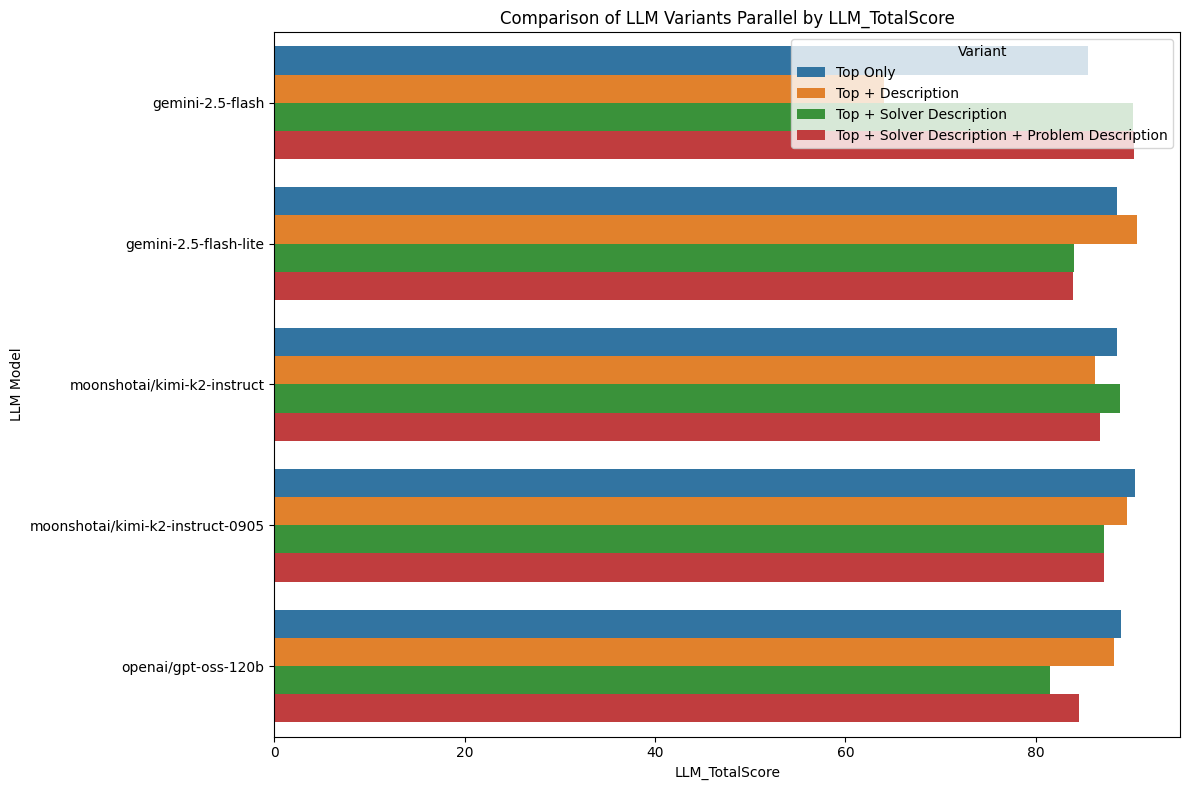

In [147]:
# --- Plot comparison of LLM variants ---
def plot_llm_variant_comparison(summaries, variant_names, label):
    combined_df = pd.DataFrame()
    for summary, name in zip(summaries, variant_names):
        temp_df = summary.copy()
        temp_df['Variant'] = name
        combined_df = pd.concat([combined_df, temp_df], ignore_index=True)

    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=combined_df,
        x=label,
        y='model',
        hue='Variant'
    )
    plt.title('Comparison of LLM Variants Parallel by ' + label)
    plt.xlabel(label)
    plt.ylabel('LLM Model')
    plt.legend(title='Variant')
    plt.tight_layout()
    plt.show()

plot_llm_variant_comparison(
    [llmT_summary, llmTD_summary, llmTSD_summary, llmTSDPD_summary],
    ['Top Only', 'Top + Description', 'Top + Solver Description', 'Top + Solver Description + Problem Description'],
    'LLM_TotalScore'
)

In [148]:
with open('./data/allTables_open.json', 'r') as f7:
    MznResultsOpen = json.load(f7)

df_open = mznResultsFlattener(MznResultsOpen)
# Inspect the result
display(df_open.head())

,Problem,Category,Instance,Solver,Status,Time,Objective,Score,Score Area
0,EchoSched,MIN,12-12-0-1_7,atlantis-free,UNK,1200000.0,NaN,0.00,1200000.00
1,EchoSched,MIN,12-12-0-1_7,cbc-par,S,1200000.0,12138.0,6.00,317587.42
2,EchoSched,MIN,12-12-0-1_7,choco-solver__cp_-par,SC,23934.0,12135.0,12.83,20153.98
3,EchoSched,MIN,12-12-0-1_7,choco-solver__cp-sat_-par,SC,21290.0,12135.0,13.05,13682.73
4,EchoSched,MIN,12-12-0-1_7,chuffed-free,SC,6508.0,12135.0,16.02,4352.61


In [149]:
# Work on a copy
scored_df_open = df_open.copy()

scored_df_open = scoreComputation(scored_df_open)
display(scored_df_open.head())


/tmp/ipykernel_5851/1335936071.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg = valid_objs.groupby(['Problem', 'Instance']).apply(best_worst).reset_index()


,Problem,Category,Instance,Solver,Status,Time,Objective,Score,Score Area,best,worst,DerivedStatus,ComputedScore
0,EchoSched,MIN,12-12-0-1_7,atlantis-free,UNK,1200000.0,NaN,0.00,1200000.00,12137.0,12213.0,UNK,0.000000
1,EchoSched,MIN,12-12-0-1_7,cbc-par,S,1200000.0,12138.0,6.00,317587.42,12137.0,12213.0,SAT,0.743421
2,EchoSched,MIN,12-12-0-1_7,choco-solver__cp_-par,SC,23934.0,12135.0,12.83,20153.98,12137.0,12213.0,OPT,1.000000
3,EchoSched,MIN,12-12-0-1_7,choco-solver__cp-sat_-par,SC,21290.0,12135.0,13.05,13682.73,12137.0,12213.0,OPT,1.000000
4,EchoSched,MIN,12-12-0-1_7,chuffed-free,SC,6508.0,12135.0,16.02,4352.61,12137.0,12213.0,OPT,1.000000


In [150]:
# Now we merge LLMvariants 
llmT_summary['LLMvariant'] = 'Top'
llmTD_summary['LLMvariant'] = 'Top+Desc'
llmTSD_summary['LLMvariant'] = 'Top+SDesc'
llmTSDPD_summary['LLMvariant'] = 'Top+SDesc+PDesc'
llm_variants_summary = pd.concat([llmT_summary, llmTD_summary, llmTSD_summary, llmTSDPD_summary], ignore_index=True)

# We create a column to put together model and LLMvariant
llm_variants_summary['Model_Variant'] = llm_variants_summary['model'] + ' (' + llm_variants_summary['LLMvariant'] + ')'
# We drop rows with InstancesCovered < 100
llm_variants_summary = llm_variants_summary[llm_variants_summary['InstancesCovered'] >= 100]
# We drop useless columns
llm_variants_summary = llm_variants_summary.drop(columns=['provider', 'InstancesCovered', 'model', 'LLMvariant', 'LLM_AvgScore'])
display(llm_variants_summary.sort_values('LLM_TotalScore', ascending=False))

,LLM_TotalScore,Model_Variant
6,90.612873,gemini-2.5-flash-lite (Top+Desc)
3,90.376892,moonshotai/kimi-k2-instruct-0905 (Top)
15,90.362873,gemini-2.5-flash (Top+SDesc+PDesc)
10,90.208707,gemini-2.5-flash (Top+SDesc)
8,89.523172,moonshotai/kimi-k2-instruct-0905 (Top+Desc)
4,88.902745,openai/gpt-oss-120b (Top)
12,88.856567,moonshotai/kimi-k2-instruct (Top+SDesc)
1,88.513084,gemini-2.5-flash-lite (Top)
2,88.484023,moonshotai/kimi-k2-instruct (Top)
9,88.168273,openai/gpt-oss-120b (Top+Desc)


In [151]:
open_solver_scores = singleSolverScore(scored_df_open)
display(open_solver_scores)

,Solver,TotalScore
14,or-tools_cp-sat-par,93.617745
4,chuffed-free,75.551585
16,picatsat-free,71.344867
11,huub-free,70.309683
12,izplus-par,65.752607
15,or-tools_cp-sat_ls-par,65.703827
3,choco-solver__cp_-par,65.461042
9,gurobi-par,64.963022
8,gecode_dexter-open,63.451294
5,cp_optimizer-par,63.434331


In [152]:
# We put together both solver total score and LLM total score, to see how LLMs compare to single solvers
llm_totscores_open = llm_variants_summary.copy()
# Rename LLM_Top1_TotalScore to TotalScore and model to Solver
llm_totscores_open = llm_totscores_open.rename(columns={'LLM_TotalScore':'TotalScore', 'Model_Variant': 'Solver'})
# We add a 'type' column to distinguish LLMs from solvers
llm_totscores_open['Type'] = 'LLM'
open_solver_scores['Type'] = 'Solver'
frames = [llm_totscores_open, open_solver_scores]
generalScores_open = pd.concat(frames)
generalScores_open_df = pd.DataFrame(generalScores_open).sort_values('TotalScore', ascending=False)
display(generalScores_open_df)

,TotalScore,Solver,Type
14,93.617745,or-tools_cp-sat-par,Solver
6,90.612873,gemini-2.5-flash-lite (Top+Desc),LLM
3,90.376892,moonshotai/kimi-k2-instruct-0905 (Top),LLM
15,90.362873,gemini-2.5-flash (Top+SDesc+PDesc),LLM
10,90.208707,gemini-2.5-flash (Top+SDesc),LLM
8,89.523172,moonshotai/kimi-k2-instruct-0905 (Top+Desc),LLM
4,88.902745,openai/gpt-oss-120b (Top),LLM
12,88.856567,moonshotai/kimi-k2-instruct (Top+SDesc),LLM
1,88.513084,gemini-2.5-flash-lite (Top),LLM
2,88.484023,moonshotai/kimi-k2-instruct (Top),LLM


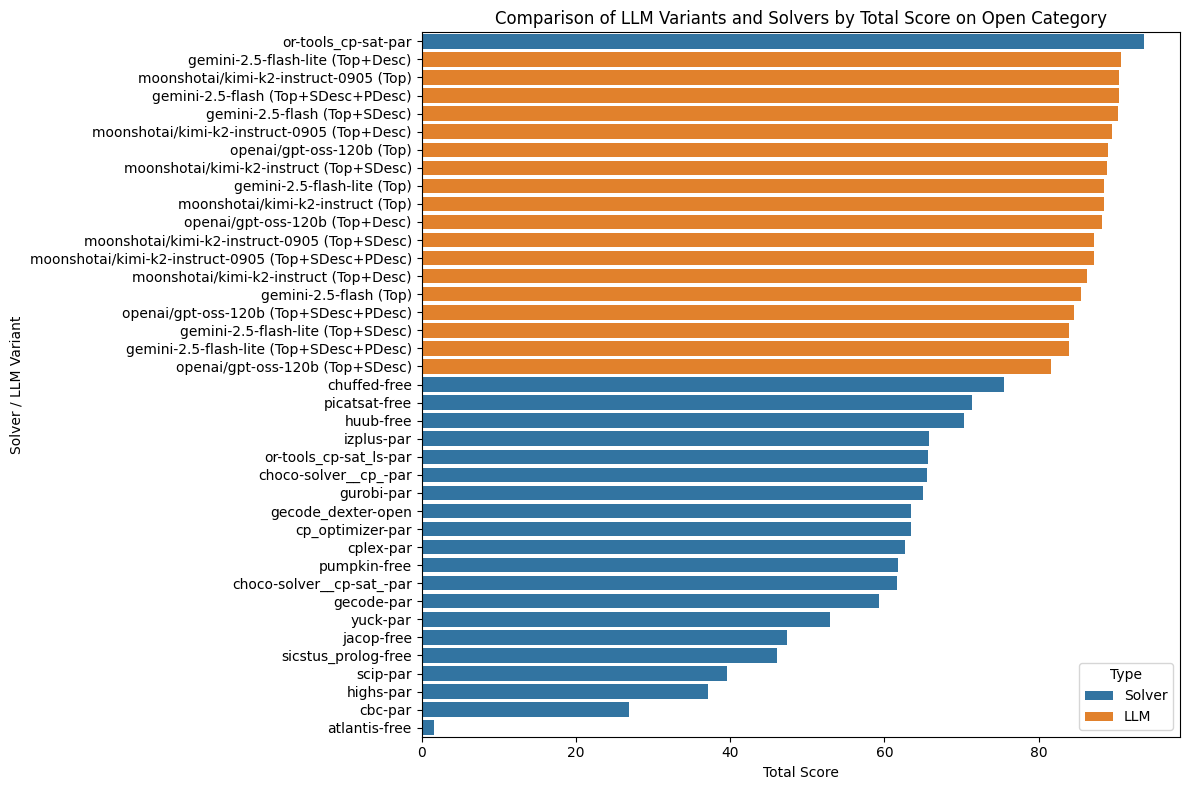

In [153]:
# We plot the comparison
plt.figure(figsize=(12, 8))
sns.barplot(
    data=generalScores_open_df,
    x='TotalScore',
    y='Solver',
    hue='Type'
)
plt.title('Comparison of LLM Variants and Solvers by Total Score on Open Category')
plt.xlabel('Total Score')
plt.ylabel('Solver / LLM Variant')
plt.tight_layout()
plt.show()

## Top 1 Evaluation

In [154]:
# --- Compute Top-1 LLM scores for different variants ---
llmT_top1_summary, llmT_top1_scored = compute_top1_llm_scores(llmT_df, scored_df)
print('Top LLM Top-1 Summary:')
display(llmT_top1_summary)

llmTD_top1_summary, llmTD_top1_scored = compute_top1_llm_scores(llmTD_df, scored_df)
print('Top+Desc LLM Top-1 Summary:')
display(llmTD_top1_summary)

llmTSD_top1_summary, llmTSD_top1_scored = compute_top1_llm_scores(llmTSD_df, scored_df)
print('Top+SDesc LLM Top-1 Summary:')
display(llmTSD_top1_summary)

llmTSDPD_top1_summary, llmTSDPD_top1_scored = compute_top1_llm_scores(llmTSDPD_df, scored_df)
print('Top+SDesc+PDesc LLM Top-1 Summary:')
display(llmTSDPD_top1_summary)

Top LLM Top-1 Summary:


,provider,model,LLM_Top1_TotalScore,LLM_Top1_AvgScore,InstancesCovered
1,gemini,gemini-2.5-flash-lite,77.277879,0.796679,100
0,gemini,gemini-2.5-flash,77.013464,0.802224,98
4,groq,openai/gpt-oss-120b,75.994607,0.759946,100
3,groq,moonshotai/kimi-k2-instruct-0905,75.982892,0.791488,100
2,groq,moonshotai/kimi-k2-instruct,74.703498,0.762281,100


Top+Desc LLM Top-1 Summary:


,provider,model,LLM_Top1_TotalScore,LLM_Top1_AvgScore,InstancesCovered
3,groq,moonshotai/kimi-k2-instruct-0905,76.690567,0.790624,100
4,groq,openai/gpt-oss-120b,73.496956,0.742393,100
1,gemini,gemini-2.5-flash-lite,73.377932,0.764353,100
2,groq,moonshotai/kimi-k2-instruct,71.385935,0.759425,100
0,gemini,gemini-2.5-flash,55.779352,0.785625,73


Top+SDesc LLM Top-1 Summary:


,provider,model,LLM_Top1_TotalScore,LLM_Top1_AvgScore,InstancesCovered
2,chat,moonshotai/kimi-k2-instruct,81.299457,0.812995,100
3,chat,moonshotai/kimi-k2-instruct-0905,81.299457,0.812995,100
0,chat,gemini-2.5-flash,76.261651,0.762617,100
4,chat,openai/gpt-oss-120b,73.108812,0.738473,100
1,chat,gemini-2.5-flash-lite,59.589395,0.595894,100


Top+SDesc+PDesc LLM Top-1 Summary:


,provider,model,LLM_Top1_TotalScore,LLM_Top1_AvgScore,InstancesCovered
0,chat,gemini-2.5-flash,81.386695,0.813867,100
3,chat,moonshotai/kimi-k2-instruct-0905,81.299457,0.812995,100
4,chat,openai/gpt-oss-120b,81.095936,0.819151,100
2,chat,moonshotai/kimi-k2-instruct,78.299457,0.790904,99
1,chat,gemini-2.5-flash-lite,66.398076,0.663981,100


In [155]:
# Ensure consistent string types
llmTSDPD_top1_scored['problem'] = llmTSDPD_top1_scored['problem'].astype(str)
llmTSDPD_top1_scored['instance'] = llmTSDPD_top1_scored['instance'].astype(str)
scored_df['Problem'] = scored_df['Problem'].astype(str)
scored_df['Instance'] = scored_df['Instance'].astype(str)

# Rows where the merge produced no ComputedScore (NaN)
missing = llmTSDPD_top1_scored[llmTSDPD_top1_scored['ComputedScore'].isna()].copy()
print(f"Total missing scored entries after merge: {len(missing)}")

# Summary by (provider, model)
missing_summary = (
    missing
    .groupby(['provider', 'model'], as_index=False)
    .agg(
        MissingInstances=('instance', 'nunique'),
        MissingRows=('instance', 'size')
    )
    .sort_values('MissingInstances', ascending=False)
)
print("Missing summary by provider/model:")
display(missing_summary)

# Build a lookup of available solvers (as strings) for each
solvers_lookup = (
    scored_df
    .groupby(['Problem', 'Instance'])['Solver']
    .apply(lambda s: sorted(set(map(str, s))))
    .to_dict()
)

if not missing.empty:
    # Add available solvers for context to help debug mismatch causes
    def available_solvers(row):
        key = (row['problem'], row['instance'])
        return solvers_lookup.get(key, [])

    missing['AvailableSolvers'] = missing.apply(available_solvers, axis=1)

    # Show distinct missing entries with useful columns
    display( missing)
else:
    print('No missing computed-score rows found in llm_top1_scored.')

# Show scored instances that the LLM never covered at all (optional)
all_instances = set(zip(scored_df['Problem'], scored_df['Instance']))
covered_by_llm = set(zip(llmTSD_top1_scored['problem'], llmTSD_top1_scored['instance']))
not_covered = sorted(list(all_instances - covered_by_llm))
print(f"\nInstances present in scored_df but not covered by any top1 in the LLM data: {len(not_covered)} (showing up to 50)")
for prob, inst in not_covered[:50]:
    print(prob, inst)

Total missing scored entries after merge: 1
Missing summary by provider/model:


,provider,model,MissingInstances,MissingRows
0,chat,openai/gpt-oss-120b,1,1


,provider,model,problem,instance,top3_list,top3,Solver,time_seconds,LLMvariant,Problem,Instance,ComputedScore,AvailableSolvers
416,chat,openai/gpt-oss-120b,cgt,cgt_3_h39_r0.05_s1_3,"[choco-solver__cp_-par, or-tools_cp-sat_ls-fre...","choco-solver__cp_-par, or-tools_cp-sat_ls-free...",choco-solver__cp_-par,NaN,Top+SDesc+PDesc,NaN,NaN,NaN,"[atlantis-free, cbc-free, choco-solver__cp-sat..."



Instances present in scored_df but not covered by any top1 in the LLM data: 0 (showing up to 50)


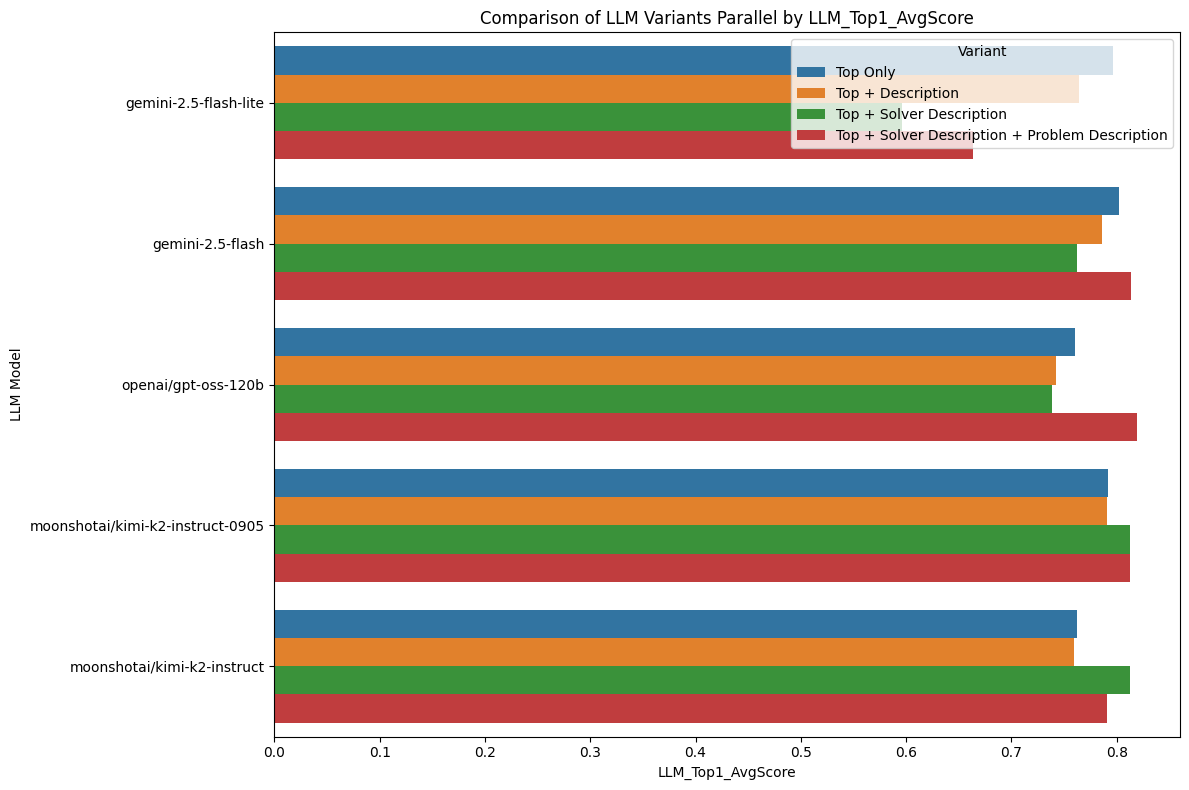

In [156]:
# --- Plot comparison of LLM top1 score variants ---
plot_llm_variant_comparison(
    [llmT_top1_summary, llmTD_top1_summary, llmTSD_top1_summary, llmTSDPD_top1_summary],
    ['Top Only', 'Top + Description', 'Top + Solver Description', 'Top + Solver Description + Problem Description'],
    'LLM_Top1_AvgScore'
)

In [157]:
# --- compute closed gap for different LLM variants ---
llmT_cg_results = compute_closed_gap(llmT_top1_scored, scored_df)
llmT_cg_df = pd.DataFrame(llmT_cg_results).sort_values('ClosedGap', ascending=False)
print('Top LLM Closed Gap:')
display(llmT_cg_df)

llmTD_cg_results = compute_closed_gap(llmTD_top1_scored, scored_df)
llmTD_cg_df = pd.DataFrame(llmTD_cg_results).sort_values('ClosedGap', ascending=False)
print('Top+Desc LLM Closed Gap:')
display(llmTD_cg_df)

llmTSD_cg_results = compute_closed_gap(llmTSD_top1_scored, scored_df)
llmTSD_cg_df = pd.DataFrame(llmTSD_cg_results).sort_values('ClosedGap', ascending=False)
print('Top+SDesc LLM Closed Gap:')
display(llmTSD_cg_df)

llmTSDPD_cg_results = compute_closed_gap(llmTSDPD_top1_scored, scored_df)
llmTSDPD_cg_df = pd.DataFrame(llmTSDPD_cg_results).sort_values('ClosedGap', ascending=False)
print('Top+SDesc+PDesc LLM Closed Gap:')
display(llmTSDPD_cg_df)

Top LLM Closed Gap:


,provider,model,InstancesCovered,AS,SBS,VBS,ClosedGap
0,gemini,gemini-2.5-flash,98,77.013464,79.674457,97.0,-0.153588
1,gemini,gemini-2.5-flash-lite,100,77.277879,81.299457,99.0,-0.227201
4,groq,openai/gpt-oss-120b,100,75.994607,81.299457,99.0,-0.299700
3,groq,moonshotai/kimi-k2-instruct-0905,100,75.982892,81.299457,99.0,-0.300362
2,groq,moonshotai/kimi-k2-instruct,100,74.703498,81.299457,99.0,-0.372642


Top+Desc LLM Closed Gap:


,provider,model,InstancesCovered,AS,SBS,VBS,ClosedGap
3,groq,moonshotai/kimi-k2-instruct-0905,100,76.690567,81.299457,99.0,-0.260381
0,gemini,gemini-2.5-flash,73,55.779352,59.306265,72.0,-0.277847
4,groq,openai/gpt-oss-120b,100,73.496956,81.299457,99.0,-0.440806
1,gemini,gemini-2.5-flash-lite,100,73.377932,81.299457,99.0,-0.447530
2,groq,moonshotai/kimi-k2-instruct,100,71.385935,81.299457,99.0,-0.560069


Top+SDesc LLM Closed Gap:


,provider,model,InstancesCovered,AS,SBS,VBS,ClosedGap
2,chat,moonshotai/kimi-k2-instruct,100,81.299457,81.299457,99.0,8.028485e-16
3,chat,moonshotai/kimi-k2-instruct-0905,100,81.299457,81.299457,99.0,8.028485e-16
0,chat,gemini-2.5-flash,100,76.261651,81.299457,99.0,-2.846131e-01
4,chat,openai/gpt-oss-120b,100,73.108812,81.299457,99.0,-4.627341e-01
1,chat,gemini-2.5-flash-lite,100,59.589395,81.299457,99.0,-1.226519e+00


Top+SDesc+PDesc LLM Closed Gap:


,provider,model,InstancesCovered,AS,SBS,VBS,ClosedGap
0,chat,gemini-2.5-flash,100,81.386695,81.299457,99.0,4.928542e-03
3,chat,moonshotai/kimi-k2-instruct-0905,100,81.299457,81.299457,99.0,8.028485e-16
4,chat,openai/gpt-oss-120b,100,81.095936,81.299457,99.0,-1.149801e-02
2,chat,moonshotai/kimi-k2-instruct,99,78.299457,80.299457,98.0,-1.129909e-01
1,chat,gemini-2.5-flash-lite,100,66.398076,81.299457,99.0,-8.418601e-01


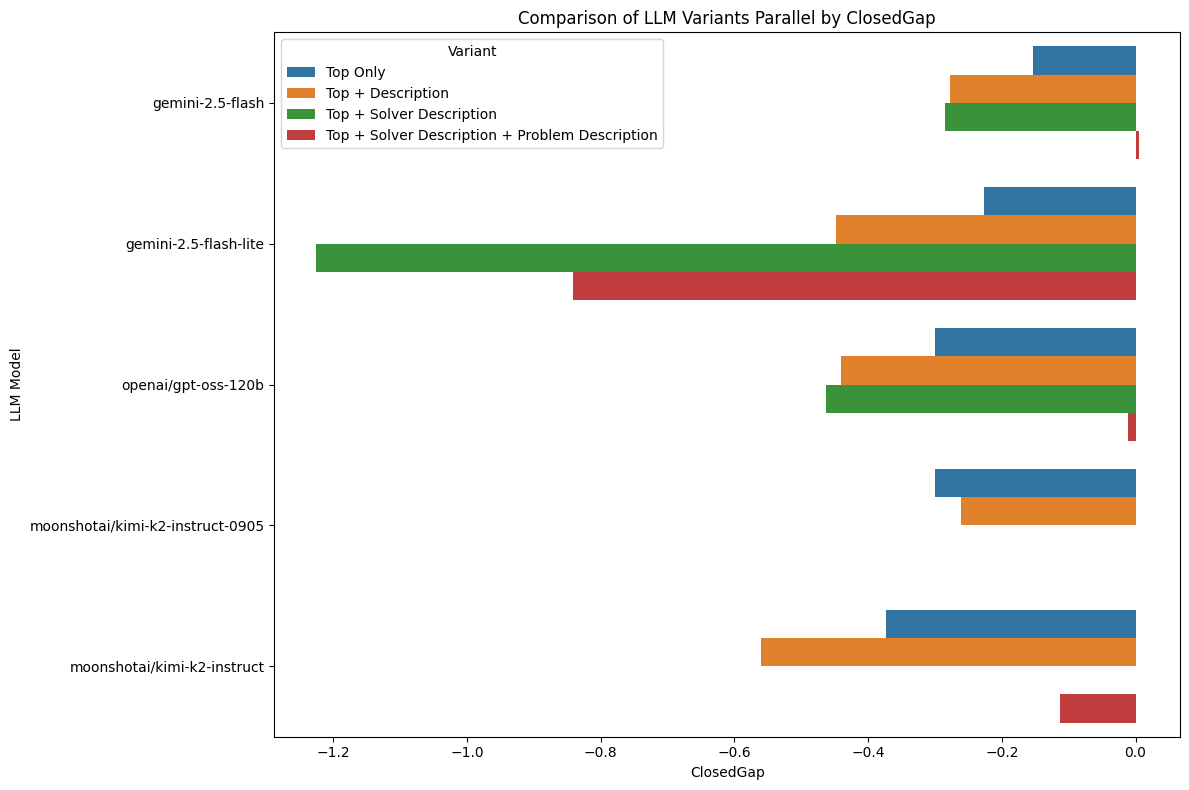

In [158]:
# --- Plot comparison of closedgap in LLM variants ---
plot_llm_variant_comparison(
    [llmT_cg_df, llmTD_cg_df, llmTSD_cg_df, llmTSDPD_cg_df],
    ['Top Only', 'Top + Description', 'Top + Solver Description', 'Top + Solver Description + Problem Description'],
    'ClosedGap'
)

## General Evaluation
We make a general evaluation of model performances against single solver performances, to get a broad view on how good of reults we are getting compared to base solvers.

In [159]:
# Now we merge all LLM variants together for direct comparison and renaming each LLM model accordingly
def merge_llm_variants(*summaries, variant_labels):
    merged_df = pd.DataFrame()
    for summary, label in zip(summaries, variant_labels):
        temp_df = summary.copy()
        temp_df['Model_Variant'] = temp_df['model'] + ' (' + label + ')'
        merged_df = pd.concat([merged_df, temp_df], ignore_index=True)
    return merged_df
merged_llm_summary = merge_llm_variants(
    llmT_top1_summary, llmTD_top1_summary, llmTSD_top1_summary, llmTSDPD_top1_summary,
    variant_labels=['Simple', 'Problem Description', 'Solvers Description', 'Solvers Description + Problem Description']
)
print('Merged LLM Summary with Variants:')
display(merged_llm_summary.sort_values('LLM_Top1_TotalScore', ascending=False))

Merged LLM Summary with Variants:


,provider,model,LLM_Top1_TotalScore,LLM_Top1_AvgScore,InstancesCovered,Model_Variant
15,chat,gemini-2.5-flash,81.386695,0.813867,100,gemini-2.5-flash (Solvers Description + Proble...
11,chat,moonshotai/kimi-k2-instruct-0905,81.299457,0.812995,100,moonshotai/kimi-k2-instruct-0905 (Solvers Desc...
10,chat,moonshotai/kimi-k2-instruct,81.299457,0.812995,100,moonshotai/kimi-k2-instruct (Solvers Description)
16,chat,moonshotai/kimi-k2-instruct-0905,81.299457,0.812995,100,moonshotai/kimi-k2-instruct-0905 (Solvers Desc...
17,chat,openai/gpt-oss-120b,81.095936,0.819151,100,openai/gpt-oss-120b (Solvers Description + Pro...
18,chat,moonshotai/kimi-k2-instruct,78.299457,0.790904,99,moonshotai/kimi-k2-instruct (Solvers Descripti...
0,gemini,gemini-2.5-flash-lite,77.277879,0.796679,100,gemini-2.5-flash-lite (Simple)
1,gemini,gemini-2.5-flash,77.013464,0.802224,98,gemini-2.5-flash (Simple)
5,groq,moonshotai/kimi-k2-instruct-0905,76.690567,0.790624,100,moonshotai/kimi-k2-instruct-0905 (Problem Desc...
12,chat,gemini-2.5-flash,76.261651,0.762617,100,gemini-2.5-flash (Solvers Description)


In [160]:
# We put together both solver total score and LLM variants total score, to see how LLMs compare to single solvers
llm_totscores = merged_llm_summary.copy()

# Rename LLM_Top1_TotalScore to TotalScore and Model_Variant to Solver
llm_totscores = llm_totscores.rename(columns={'LLM_Top1_TotalScore':'TotalScore', 'Model_Variant': 'Solver'})
# We drop LLM_Top1_AvgScore, InstancesCovered, model and provider columns
llm_totscores = llm_totscores.drop(columns=['LLM_Top1_AvgScore', 'InstancesCovered', 'model', 'provider'])

# We add a column to distinguish solver from LLM variants
llm_totscores['Type'] = 'LLM Variant'
score_solvers_df['Type'] = 'Solver'
frames = [llm_totscores, score_solvers_df]
generalScores = pd.concat(frames)

generalScores_df = pd.DataFrame(generalScores).sort_values('TotalScore', ascending=False)
print('General Scores (LLM variants + Solvers):')
display(generalScores_df)

General Scores (LLM variants + Solvers):


,TotalScore,Solver,Type
15,81.386695,gemini-2.5-flash (Solvers Description + Proble...,LLM Variant
16,81.299457,moonshotai/kimi-k2-instruct-0905 (Solvers Desc...,LLM Variant
11,81.299457,moonshotai/kimi-k2-instruct-0905 (Solvers Desc...,LLM Variant
10,81.299457,moonshotai/kimi-k2-instruct (Solvers Description),LLM Variant
13,81.299457,or-tools_cp-sat-free,Solver
17,81.095936,openai/gpt-oss-120b (Solvers Description + Pro...,LLM Variant
18,78.299457,moonshotai/kimi-k2-instruct (Solvers Descripti...,LLM Variant
0,77.277879,gemini-2.5-flash-lite (Simple),LLM Variant
1,77.013464,gemini-2.5-flash (Simple),LLM Variant
5,76.690567,moonshotai/kimi-k2-instruct-0905 (Problem Desc...,LLM Variant


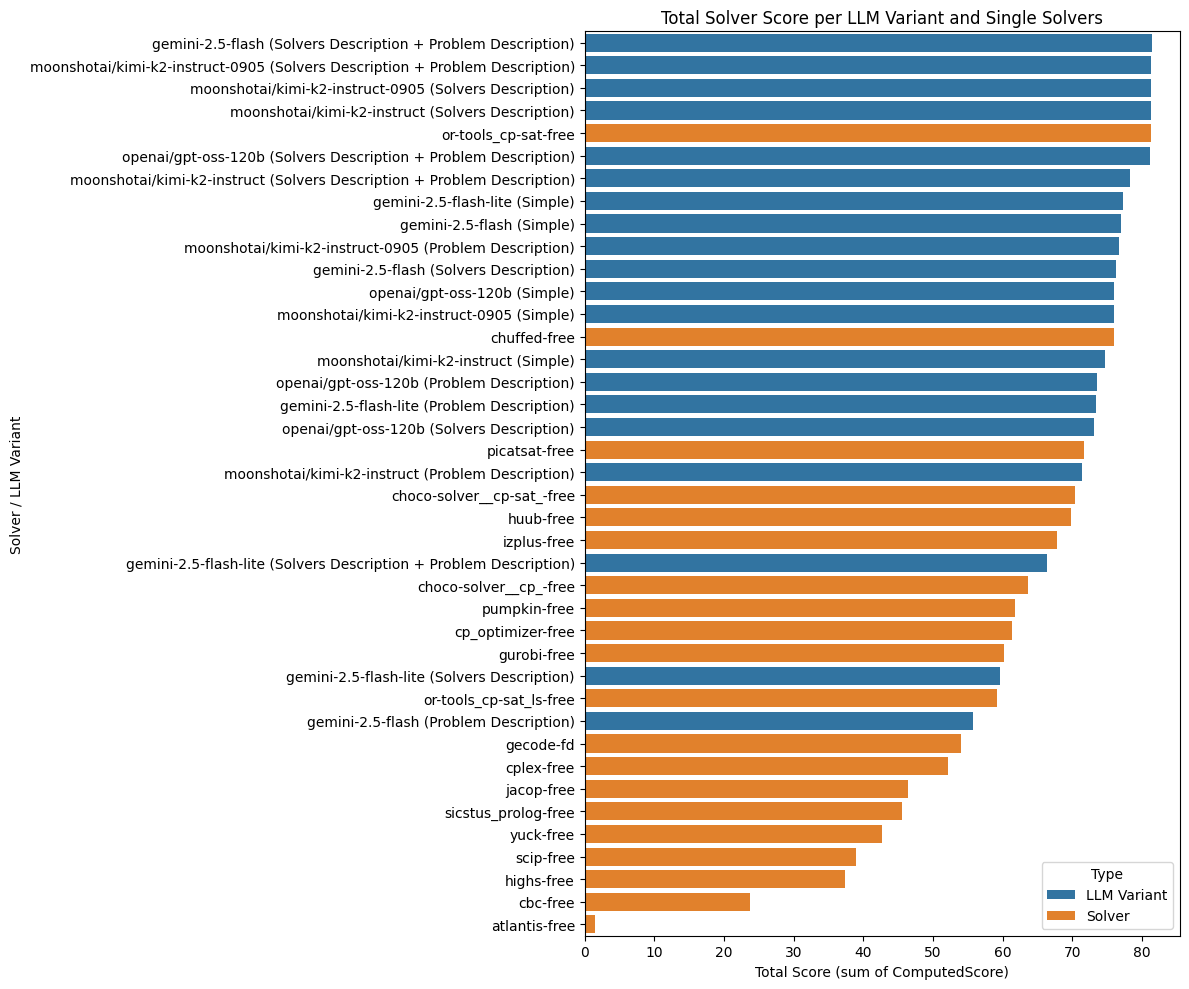

In [161]:
# We plot the merged results, giving different color depending on type column (LLM Variant vs Solver)


plot_df = generalScores_df.sort_values('TotalScore', ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(
    x=plot_df['TotalScore'], 
    y=plot_df['Solver'],
    hue=plot_df['Type']
)
plt.title("Total Solver Score per LLM Variant and Single Solvers")
plt.xlabel("Total Score (sum of ComputedScore)")
plt.ylabel("Solver / LLM Variant")
plt.tight_layout()
plt.show()

## Suggetions Content Analysis
For each LLM, we wanna count how many times each of the solvers has been suggested as the Top 1, or in the Top 3

In [162]:
# For each LLM variant, we count the number of appearences as top 1 for each solver
llm_variant_solver_counts = (
    all_llm_df[all_llm_df['top1'].notnull()]
    .rename(columns={'top1': 'Solver'})
    .groupby(['LLMvariant', 'model', 'Solver'])
    .size()
    .reset_index(name='Top1_Appearances')
    .sort_values(['Top1_Appearances'], ascending=[False])
)
print('LLM Variant Top-1 Appearances per Solver:')
display(llm_variant_solver_counts.head(20))


LLM Variant Top-1 Appearances per Solver:


,LLMvariant,model,Solver,Top1_Appearances
55,Top+SDesc,moonshotai/kimi-k2-instruct,or-tools_cp-sat-free,100
76,Top+SDesc+PDesc,moonshotai/kimi-k2-instruct-0905,or-tools_cp-sat-free,100
57,Top+SDesc,moonshotai/kimi-k2-instruct-0905,or-tools_cp-sat-free,99
22,Top,openai/gpt-oss-120b,chuffed-free,97
74,Top+SDesc+PDesc,moonshotai/kimi-k2-instruct,or-tools_cp-sat-free,96
47,Top+Desc,openai/gpt-oss-120b,chuffed-free,93
34,Top+Desc,gemini-2.5-flash-lite,or-tools_cp-sat-free,88
11,Top,gemini-2.5-flash-lite,or-tools_cp-sat-free,86
67,Top+SDesc+PDesc,gemini-2.5-flash,or-tools_cp-sat-free,85
51,Top+SDesc,gemini-2.5-flash,or-tools_cp-sat-free,78


In [163]:
# Now we want to plot how many times each model suggests the SBS solver as top 1
sbs_solver_name = 'or-tools_cp-sat-free'
sbs_appearances = llm_variant_solver_counts[llm_variant_solver_counts['Solver'] == sbs_solver_name]
print(f"SBS Solver ('{sbs_solver_name}') Top-1 Appearances by LLM Variant and Model:")
display(sbs_appearances)

SBS Solver ('or-tools_cp-sat-free') Top-1 Appearances by LLM Variant and Model:


,LLMvariant,model,Solver,Top1_Appearances
55,Top+SDesc,moonshotai/kimi-k2-instruct,or-tools_cp-sat-free,100
76,Top+SDesc+PDesc,moonshotai/kimi-k2-instruct-0905,or-tools_cp-sat-free,100
57,Top+SDesc,moonshotai/kimi-k2-instruct-0905,or-tools_cp-sat-free,99
74,Top+SDesc+PDesc,moonshotai/kimi-k2-instruct,or-tools_cp-sat-free,96
34,Top+Desc,gemini-2.5-flash-lite,or-tools_cp-sat-free,88
11,Top,gemini-2.5-flash-lite,or-tools_cp-sat-free,86
67,Top+SDesc+PDesc,gemini-2.5-flash,or-tools_cp-sat-free,85
51,Top+SDesc,gemini-2.5-flash,or-tools_cp-sat-free,78
81,Top+SDesc+PDesc,openai/gpt-oss-120b,or-tools_cp-sat-free,77
4,Top,gemini-2.5-flash,or-tools_cp-sat-free,72


## Inverse Calculation
We evaluate the problem on which models had worst and bet results

In [164]:
# Aggregate total Top-1 score per (problem, instance) across all LLM variants and list ascending
def aggregate_llm_instance_scores(*llm_scored_dfs):
    combined = pd.concat(llm_scored_dfs, ignore_index=True)
    # Treat missing merged ComputedScore as 0 (LLM didn't match a scored solver)
    combined['ComputedScore'] = combined['ComputedScore'].fillna(0.0)
    # Ensure keys are strings
    combined['problem'] = combined['problem'].astype(str)
    combined['instance'] = combined['instance'].astype(str)
    # Aggregate
    inst_scores = combined.groupby(['problem', 'instance'], as_index=False).agg(
        TotalLLMScore=('ComputedScore', 'sum'),
        ModelsSeen=('model', 'nunique'),
        PredictionsCount=('Solver', 'count')
    )
    inst_scores_sorted = inst_scores.sort_values('TotalLLMScore', ascending=True).reset_index(drop=True)
    return inst_scores_sorted

inst_scores_sorted = aggregate_llm_instance_scores(
    llmT_top1_scored, llmTD_top1_scored, llmTSD_top1_scored, llmTSDPD_top1_scored
)

print('Instances sorted (ascending) by combined LLM Top-1 Total Score:')
display(inst_scores_sorted)

# Show the worst-scored instances (bottom 5)
print('\nBottom 5 instances (least total LLM score):')
display(inst_scores_sorted.head(5))

Instances sorted (ascending) by combined LLM Top-1 Total Score:


,problem,instance,TotalLLMScore,ModelsSeen,PredictionsCount
0,gt-sort,n9_ub30_35.0_BEST,0.000000,5,19
1,ihtc-2024-marte,i11,0.000000,5,19
2,gt-sort,n13_ub20_50.0_BEST,0.000000,5,20
3,tsptw,n80w180.003,0.000000,5,20
4,ihtc-2024-marte,i14,0.649293,5,20
...,...,...,...,...,...
95,groupsplitter,u12g2pref0,20.000000,5,20
96,gt-sort,n9_ub10_50.0_BEST,20.000000,5,20
97,hitori,h11-1,20.000000,5,20
98,skill-allocation,skill_allocation_mzn_2w_2,20.000000,5,20



Bottom 5 instances (least total LLM score):


,problem,instance,TotalLLMScore,ModelsSeen,PredictionsCount
0,gt-sort,n9_ub30_35.0_BEST,0.000000,5,19
1,ihtc-2024-marte,i11,0.000000,5,19
2,gt-sort,n13_ub20_50.0_BEST,0.000000,5,20
3,tsptw,n80w180.003,0.000000,5,20
4,ihtc-2024-marte,i14,0.649293,5,20


In [165]:
# Now we calculate worst performed problmes by aggregating data from the instances contained in inst_scores_sorted
# We merge inst_scores_sorted with scored_df to get problem categories
inst_scores_with_cat = inst_scores_sorted.merge(
    scored_df[['Problem', 'Instance', 'Category']].drop_duplicates(),
    left_on=['problem', 'instance'],
    right_on=['Problem', 'Instance'],
    how='left'
)
# Aggregate total LLM score per problem
problem_scores = inst_scores_with_cat.groupby(['problem', 'Category'], as_index=False).agg(
    ProblemTotalLLMScore=('TotalLLMScore', 'sum'),
    InstanceCount=('instance', 'nunique')
)
# Sort problems by total LLM score ascending
problem_scores_sorted = problem_scores.sort_values('ProblemTotalLLMScore', ascending=True).reset_index(drop=True)
print('Problems sorted (ascending) by combined LLM Top-1 Total Score:')
display(problem_scores_sorted)

Problems sorted (ascending) by combined LLM Top-1 Total Score:


,problem,Category,ProblemTotalLLMScore,InstanceCount
0,ihtc-2024-marte,MIN,33.273070,5
1,gt-sort,MIN,42.166667,5
2,cgt,MIN,50.620565,5
3,tsptw,MIN,53.869565,5
4,work-task-variation,MIN,61.892584,5
5,skill-allocation,MIN,65.835812,5
6,atsp,MIN,69.807248,5
7,mondoku,MIN,71.750000,5
8,ihtc-2024-kletzander,MIN,72.975658,5
9,hitori,MAX,76.043572,5


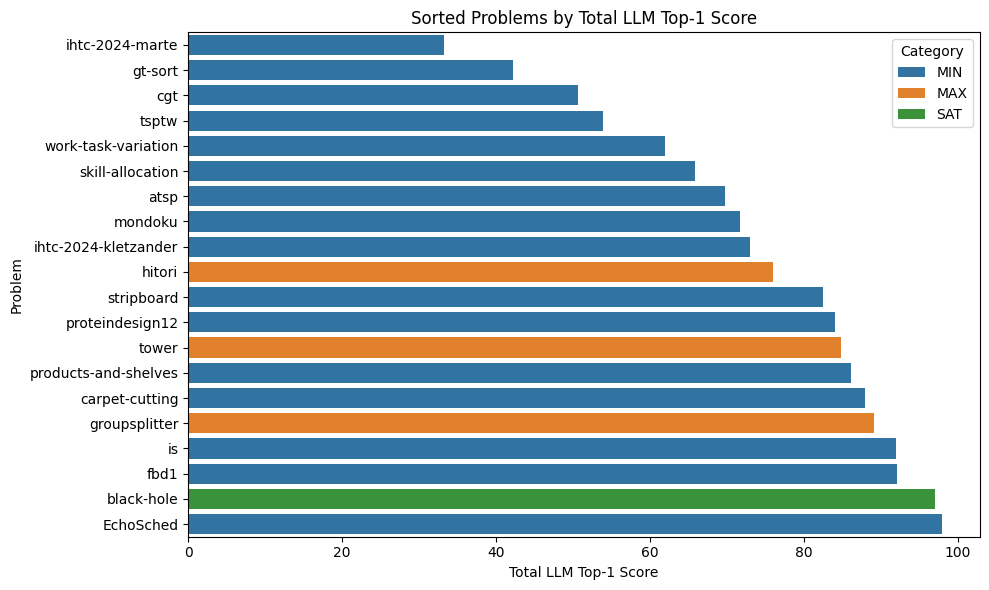

In [166]:
# Now we plot the worst performed problems
plt.figure(figsize=(10, 6))
sns.barplot(
    data=problem_scores_sorted,
    x='ProblemTotalLLMScore',
    y='problem',
    hue='Category'
)
plt.title('Sorted Problems by Total LLM Top-1 Score')
plt.xlabel('Total LLM Top-1 Score')
plt.ylabel('Problem')
plt.tight_layout()
plt.show()

In [167]:
"""GPT 5.0 Suggestions (Solver description + Problem description):
"""
# Convert the pasted GPT-5.0 suggestions into a DataFrame for further operations
gpt_suggestions = [
    {"provider": "gpt-5.0", "model": "suggestions", "problem": "gt-sort", "instance": "n9_ub30_35.0_BEST",
     "top3_list": ["chuffed-free", "izplus-free", "choco-solver__cp_-par"]},
    {"provider": "gpt-5.0", "model": "suggestions", "problem": "gt-sort", "instance": "n13_ub20_50.0_BEST",
     "top3_list": ["chuffed-free", "choco-solver__cp_-par", "cp_optimizer-free"]},
    {"provider": "gpt-5.0", "model": "suggestions", "problem": "ihtc-2024-marte", "instance": "i11",
     "top3_list": ["chuffed-free", "cp_optimizer-free", "or-tools_cp-sat-free"]},
    {"provider": "gpt-5.0", "model": "suggestions", "problem": "ihtc-2024-marte", "instance": "i14",
     "top3_list": ["or-tools_cp-sat-free", "chuffed-free", "cp_optimizer-free"]},
    {"provider": "gpt-5.0", "model": "suggestions", "problem": "tsptw", "instance": "n80w180.003",
     "top3_list": ["chuffed-free", "or-tools_cp-sat-free", "cp_optimizer-free"]},
]

gpt_df = pd.DataFrame(gpt_suggestions)
# add convenient derived columns similar to ResultsFlattener output
gpt_df["top3"] = gpt_df["top3_list"].apply(lambda L: ", ".join(L) if isinstance(L, (list, tuple)) else L)
gpt_df["top1"] = gpt_df["top3_list"].apply(lambda L: L[0] if isinstance(L, (list, tuple)) and L else None)
gpt_df["time_seconds"] = None

display(gpt_df)

,provider,model,problem,instance,top3_list,top3,top1,time_seconds
0,gpt-5.0,suggestions,gt-sort,n9_ub30_35.0_BEST,"[chuffed-free, izplus-free, choco-solver__cp_-...","chuffed-free, izplus-free, choco-solver__cp_-par",chuffed-free,None
1,gpt-5.0,suggestions,gt-sort,n13_ub20_50.0_BEST,"[chuffed-free, choco-solver__cp_-par, cp_optim...","chuffed-free, choco-solver__cp_-par, cp_optimi...",chuffed-free,None
2,gpt-5.0,suggestions,ihtc-2024-marte,i11,"[chuffed-free, cp_optimizer-free, or-tools_cp-...","chuffed-free, cp_optimizer-free, or-tools_cp-s...",chuffed-free,None
3,gpt-5.0,suggestions,ihtc-2024-marte,i14,"[or-tools_cp-sat-free, chuffed-free, cp_optimi...","or-tools_cp-sat-free, chuffed-free, cp_optimiz...",or-tools_cp-sat-free,None
4,gpt-5.0,suggestions,tsptw,n80w180.003,"[chuffed-free, or-tools_cp-sat-free, cp_optimi...","chuffed-free, or-tools_cp-sat-free, cp_optimiz...",chuffed-free,None


In [168]:
# We calculate score of GPT suggestions with gpt_df
# Compute Top-1 scores for GPT suggestions
gpt_top1 = gpt_df.copy()
gpt_top1 = gpt_top1[gpt_top1['top1'].notnull()].rename(columns={'top1': 'Solver'})
gpt_top1[['problem', 'instance', 'Solver']] = gpt_top1[['problem', 'instance', 'Solver']].astype(str)

# Ensure scored_df keys are strings
scored_df['Problem'] = scored_df['Problem'].astype(str)
scored_df['Instance'] = scored_df['Instance'].astype(str)
scored_df['Solver'] = scored_df['Solver'].astype(str)

gpt_top1_scored = gpt_top1.merge(
    scored_df[['Problem', 'Instance', 'Solver', 'ComputedScore']],
    left_on=['problem', 'instance', 'Solver'],
    right_on=['Problem', 'Instance', 'Solver'],
    how='left'
)

gpt_top1_summary = (
    gpt_top1_scored
    .groupby(['provider', 'model'], as_index=False)
    .agg(
        GPT_Top1_TotalScore=('ComputedScore', 'sum'),
        GPT_Top1_AvgScore=('ComputedScore', 'mean'),
        InstancesCovered=('instance', 'nunique')
    )
    .sort_values('GPT_Top1_TotalScore', ascending=False)
)

print("GPT Top-1 Summary:")
display(gpt_top1_summary)

# Compute Top-3 combined scores for GPT suggestions (explode top3_list)
gpt_top3 = gpt_df.copy()
gpt_top3 = gpt_top3[gpt_top3['top3_list'].notnull()].explode('top3_list').rename(columns={'top3_list': 'Solver'})
gpt_top3[['problem', 'instance', 'Solver']] = gpt_top3[['problem', 'instance', 'Solver']].astype(str)

gpt_top3_scored = gpt_top3.merge(
    scored_df[['Problem', 'Instance', 'Solver', 'ComputedScore']],
    left_on=['problem', 'instance', 'Solver'],
    right_on=['Problem', 'Instance', 'Solver'],
    how='left'
)

gpt_top3_summary = (
    gpt_top3_scored
    .groupby(['provider', 'model'], as_index=False)
    .agg(
        GPT_Top3_TotalScore=('ComputedScore', 'sum'),
        InstancesCovered=('instance', 'nunique'),
        PredictionsCount=('Solver', 'count')
    )
    .sort_values('GPT_Top3_TotalScore', ascending=False)
)

print("GPT Top-3 Combined Summary:")
display(gpt_top3_summary)

GPT Top-1 Summary:


,provider,model,GPT_Top1_TotalScore,GPT_Top1_AvgScore,InstancesCovered
0,gpt-5.0,suggestions,0.0,0.0,5


GPT Top-3 Combined Summary:


,provider,model,GPT_Top3_TotalScore,InstancesCovered,PredictionsCount
0,gpt-5.0,suggestions,0.649293,5,15
